### Подгружаем нужные библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns           
import sklearn 
%matplotlib inline

### Считываем данные

In [2]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")

Некоторые признаки являются нечисловыми: образование, семейное положение и дата первой покупки Проведем небольшой препроцессинг - Kidhome и Teenhome заменим признаком Children Нечисловые признаки заменим числовыми

In [3]:
data['children'] = (data['Kidhome'] + data['Teenhome']) > 0
data = data.drop(columns=['Kidhome', 'Teenhome', 'Z_Revenue', 'Z_CostContact'])

In [4]:
data_describe = data.describe(include = [object])
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']

Удалим стоблцы ID и Date, потому что они не несут полезной информации

In [5]:
# Remove ID column
numerical_columns = numerical_columns[1:]

# Remove Date column
nonbinary_columns = nonbinary_columns[0:-1]

In [6]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])

### Избавимся от нежелательных значений

In [7]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
children                0
dtype: int64

Заполним пропуски в колонке Income

In [8]:
data = data.fillna(data.median(axis = 0), axis = 0)

### Нормализуем данные

In [9]:
data_numerical = data[numerical_columns]
data_stand = (data_numerical - data_numerical.mean(axis = 0)) / data_numerical.std(axis = 0)
new_data = pd.concat((data['ID'].to_frame(), data_numerical, data_nonbinary), axis = 1)

### Отбор признака

In [10]:
X = new_data.drop(['ID','MntMeatProducts'], axis=1)
y = new_data['MntMeatProducts']

In [11]:
X = X.to_numpy()
y = np.array(y <= 50, dtype='int')

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

1568 672


### Обучение классификатора

In [13]:
from sklearn.neural_network import MLPClassifier

Проверка качества при одном скрытом слое

In [14]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)

mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.13329081632653061, 0.15476190476190477)

Проверка качества при двух скрытых слоях

In [15]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100, 100,), 
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.15497448979591838, 0.16666666666666666)

### Подбор оптимального параметра alpha

##### Для одного скрытого слоя

In [23]:
alpha_arr = np.logspace(-3, 2, 21)
test_err1 = []
train_err1 = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,),
                              solver = 'lbfgs', activation = 'logistic', max_iter = 1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err1.append(np.mean(y_train != y_train_pred))
    test_err1.append(np.mean(y_test != y_test_pred))

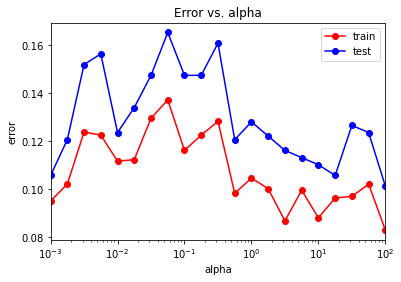

In [24]:
plt.semilogx(alpha_arr, train_err1, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err1, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])

plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [25]:
alpha_opt1 = alpha_arr[test_err1 == min(test_err1)]
print(alpha_opt1)

[100.]


По графику видно, что ошибка на тестовой выборке и ошибка на тренировочной выборке следуют одним трендам

Классификатор при найденом значении alpha = 100

In [26]:
mlp_model = MLPClassifier(alpha = 100, hidden_layer_sizes = (100), 
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.13839285714285715, 0.16517857142857142)

##### Для двух скрытых слоев

In [27]:
alpha_arr = np.logspace(-3, 2, 21)
test_err2 = []
train_err2 = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100, 100),
                              solver = 'lbfgs', activation = 'logistic', max_iter = 1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err2.append(np.mean(y_train != y_train_pred))
    test_err2.append(np.mean(y_test != y_test_pred))

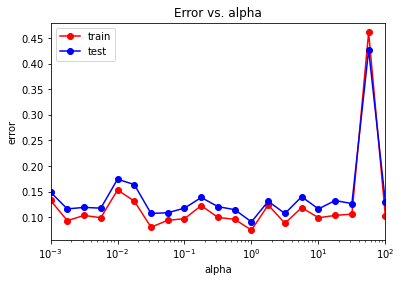

In [28]:
plt.semilogx(alpha_arr, train_err2, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err2, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])

plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [29]:
alpha_opt2 = alpha_arr[test_err2 == min(test_err2)]
print(alpha_opt2)

[1.]


Классификатор при найденом значении alpha = 1

In [30]:
mlp_model = MLPClassifier(alpha = 1, hidden_layer_sizes = (100, 100), 
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.09948979591836735, 0.1130952380952381)

### Подбор оптимального количества нейронов

##### Для одного скрытого слоя

In [72]:
neuron_numbers = np.logspace(1, 3, 20)
neuron_numbers = neuron_numbers.astype('int')
test_err1 = []
train_err1 = []
for neuron_number in neuron_numbers:
    mlp_model = MLPClassifier(alpha = alpha_opt1, hidden_layer_sizes = (neuron_number),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42, max_iter = 1000)
    
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err1.append(np.mean(y_train != y_train_pred))
    test_err1.append(np.mean(y_test != y_test_pred))

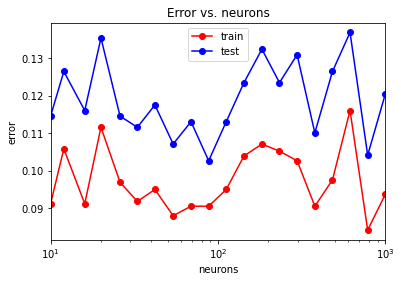

In [73]:
plt.semilogx(neuron_numbers, train_err1, 'r-o', label = 'train')
plt.semilogx(neuron_numbers, test_err1, 'b-o', label = 'test')
plt.xlim([np.min(neuron_numbers), np.max(neuron_numbers)])

plt.title('Error vs. neurons')
plt.xlabel('neurons')
plt.ylabel('error')
plt.legend()
pass

In [74]:
neurons_opt1 = neuron_numbers[test_err1 == min(test_err1)]
print(neurons_opt1)

[88]


Классификатор при оптимальном значении

In [76]:
mlp_model = MLPClassifier(alpha = 100, hidden_layer_sizes = (88), 
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.10140306122448979, 0.12351190476190477)

##### Для двух скрытых слоев

In [83]:
neuron_numbers = np.logspace(1, 2, 10)
neuron_numbers = neuron_numbers.astype('int')
test_err2 = []
train_err2 = []
sizes1 = []
sizes2 = []

for size1 in neuron_numbers:
    for size2 in neuron_numbers:
        mlp_model = MLPClassifier(alpha = alpha_opt2, hidden_layer_sizes = (size1, size2),
                              solver = 'lbfgs', activation = 'logistic', random_state = 42, max_iter = 1000)

        mlp_model.fit(X_train, y_train)

        y_train_pred = mlp_model.predict(X_train)
        y_test_pred = mlp_model.predict(X_test)

        train_err2.append(np.mean(y_train != y_train_pred))
        test_err2.append(np.mean(y_test != y_test_pred))
        sizes1.append(size1)
        sizes2.append(size2)

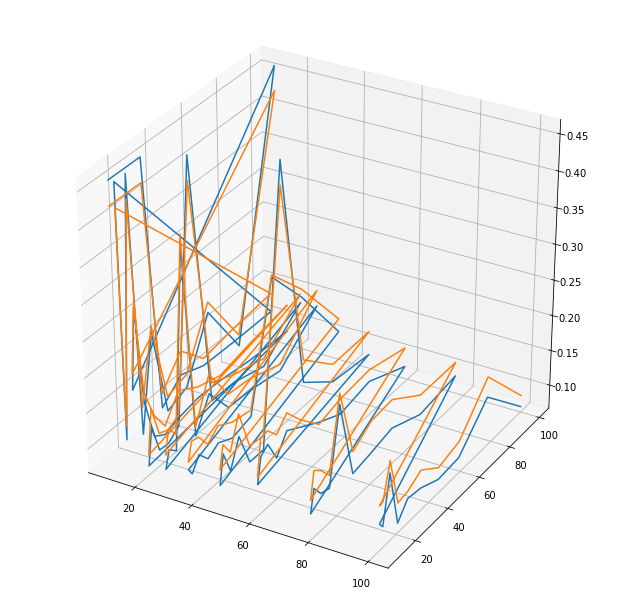

In [93]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(11,11))
ax = fig.gca(projection='3d')
ax.plot(xs=sizes1, ys=sizes2, zs=train_err2)
ax.plot(xs=sizes1, ys=sizes2, zs=test_err2)

Глядя на график легко заметить, что минимум ошибки на тестовой выборке достигается при 100 нейронах в каждом слое

In [85]:
size1_opt = sizes1[test_err2.index(min(test_err2))]
size2_opt = sizes2[test_err2.index(min(test_err2))]
print(size1_opt, size2_opt)

100 100


Классификатор при оптимальном значении

In [86]:
mlp_model = MLPClassifier(alpha = alpha_opt2, hidden_layer_sizes = (size1_opt, size2_opt), 
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.09948979591836735, 0.1130952380952381)

### Выводы

1. Зависимость ошибки от параметра alpha неясна, так как никакой монотонности не наблюдается
2. Зависимость ошибки от числа нейронов в каждом слое также не очевидна, но можно предположить, что при увеличении числа нейронов ошибка уменьшается